# Varying the Prompt: Effect on Accuracy

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from functools import partial
from pathlib import Path
import logging

from mono_multi.setup import (
    variations,
    FIGURES_ROOT_DIR,
)
from mono_multi.utils import (
    get_size_and_it,
    load_risk_scores,
    load_results_overview,
    load_data_if_needed,
    prettify_model_name,
    key_to_model,
    load_model_outputs_same_prompt,
    add_evals_to_df,
    filter_by_label,
    filter_results_all_tasks
)


from mono_multi.plotting import (
    plot_recourse_wrapper,
    plot_agreement_wrapper,
    configure_legend,
)

/Users/mgorecki/opt/miniconda3/envs/monoc-py311/lib/python3.11/site-packages/xport/__about__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
plot_config_file = "./results/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

FIGURES_PAPER_DIR = FIGURES_ROOT_DIR / "paper-arxiv" / "vary-prompt"
TASKS = ["ACSIncome"]
print("tasks", TASKS)
MODELS = [
    "Qwen--Qwen2.5-7B-Instruct",
    "Qwen--Qwen2.5-72B-Instruct",
    "meta-llama--Meta-Llama-3-8B-Instruct",
    "meta-llama--Meta-Llama-3.3-70B-Instruct",
]
variations

tasks ['ACSIncome']


{'feature_order': ['default', 'rand 1', 'rand 2', 'rand 3', ' reversed'],
 'format': ['bullet', 'text', 'comma'],
 'connector': ['is', '=', ':'],
 'granularity': ['original', 'low'],
 'example_order': ['default', 'rand 1', 'rand 2', 'rand 3', 'reversed'],
 'example_composition': ['10,0', '7,3', 'balanced', '3,7', '0,10']}

## Load available models and variations

In [4]:
try:
    data_all
except NameError:
    print("'data_all' not yet defined")
    data_all = load_data_if_needed(data=None, tasks=TASKS)
else:
    print("Already defined, update if needed.")
    data_all = load_data_if_needed(data=data_all, tasks=TASKS)

'data_all' not yet defined
ACSIncome


## Load predictions

In [5]:
num_shots = 0
threshold_fitted = True
fit_threshold_for = 'balanced_accuracy'

df = load_results_overview(
    num_shots=num_shots, threshold_fitted=threshold_fitted, same_prompt=False
)
df = df[df["task"].isin(TASKS)]
df = df[df["model"].isin(MODELS)]
df = df[df["threshold_obj"]==fit_threshold_for]

df['predictions_path'] = '/Volumes/mgorecki/monoculture/' + df['predictions_path']

df = add_evals_to_df(df)
df.shape

(301, 21)

In [6]:
try:
    assert set(TASKS).issubset(
        set(df["task"].unique())
    ), f"Results for all tasks to be analysed have to be available, available are: {list(df['task'].unique())} "
except AssertionError:
    TASKS = list(df["task"].unique())
    logging.warning(f"Reduced TASKS to available tasks: {TASKS}")

In [7]:
risk_scores = (
    df["predictions_path"]
    .apply(load_risk_scores)
    .apply(lambda x: x.squeeze())
    .add_prefix("score_")
)
# display(risk_scores.head())

# filter by label
risk_scores_only = risk_scores.transpose()
risk_scores_only.index = risk_scores_only.index.str.replace("score_", "", regex=False).astype(int)
risk_scores_only, data = filter_by_label(predictions=risk_scores_only, 
                data=data_all['ACSIncome'],
                label_val=1)

# filter out columns that are not in predictions
col_numbers = risk_scores.columns.str.extract(r"^score_(\d+)$")[0]
matching_score_cols = risk_scores.columns[col_numbers.isin(risk_scores_only.index.astype(str))]

risk_scores_filtered = risk_scores[matching_score_cols.tolist()]

# add to df
df_with_riskscores = pd.concat([df, risk_scores_filtered], axis=1)
print(df_with_riskscores.shape)
display(df_with_riskscores.head())

# turn into predictions
df_with_predictions = df_with_riskscores.copy()
model_wise_thresholds = df_with_predictions["threshold"]
df_with_predictions.update(
    df_with_predictions.filter(like="score_").apply(
        lambda col: (col >= model_wise_thresholds).astype(int)
    )
)

(301, 61254)


,task,model,is_inst,threshold_fitted,threshold,threshold_obj,accuracy,balanced_accuracy,bench_hash,num_shots,...,score_1735597,score_1550578,score_2427891,score_2089348,score_608838,score_1995426,score_3187549,score_1588752,score_926337,score_688458
0,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.033094,balanced_accuracy,0.763755,0.772159,1339497723,0,...,0.004595,0.999876,0.998077,0.007589,0.999738,0.001034,0.999860,0.999619,0.999512,0.999512
1,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.008599,balanced_accuracy,0.775843,0.781488,642741645,0,...,0.003170,0.999702,0.268712,0.269283,0.999820,0.000910,0.997532,0.999512,0.999841,0.998080
2,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.007567,balanced_accuracy,0.760535,0.765280,419256548,0,...,0.000624,0.999449,0.997812,0.001500,0.999770,0.000551,0.999842,0.999704,0.999570,0.997196
3,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.244386,balanced_accuracy,0.776642,0.775290,3671207344,0,...,0.023032,0.999770,0.957929,0.893567,0.999820,0.005897,0.999619,0.999705,0.999842,0.998081
4,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.012454,balanced_accuracy,0.755176,0.767424,2269177329,0,...,0.004065,0.999512,0.997820,0.007586,0.999570,0.001693,0.999704,0.999445,0.999446,0.998075


In [8]:
mask = df_with_predictions["task"] == "ACSIncome"
top_acc = df_with_predictions[mask]["accuracy"].max()
eps = 0.05
mask &= df_with_predictions["accuracy"] >= top_acc - eps
df_with_predictions[mask].sort_values(by="accuracy", ascending=False)

,task,model,is_inst,threshold_fitted,threshold,threshold_obj,accuracy,balanced_accuracy,bench_hash,num_shots,...,score_1735597,score_1550578,score_2427891,score_2089348,score_608838,score_1995426,score_3187549,score_1588752,score_926337,score_688458
167,ACSIncome,meta-llama--Meta-Llama-3.3-70B-Instruct,1,1,0.999336,balanced_accuracy,0.787366,0.783697,2900240062,0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
190,ACSIncome,meta-llama--Meta-Llama-3.3-70B-Instruct,1,1,0.999541,balanced_accuracy,0.785023,0.774727,3391934077,0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
35,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.294643,balanced_accuracy,0.784506,0.774093,1644217568,0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
174,ACSIncome,meta-llama--Meta-Llama-3.3-70B-Instruct,1,1,0.999447,balanced_accuracy,0.784308,0.780452,891083546,0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
195,ACSIncome,meta-llama--Meta-Llama-3.3-70B-Instruct,1,1,0.999593,balanced_accuracy,0.783527,0.783480,2358677116,0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,ACSIncome,Qwen--Qwen2.5-7B-Instruct,1,1,0.015910,balanced_accuracy,0.739495,0.757059,2976489885,0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
41,ACSIncome,Qwen--Qwen2.5-72B-Instruct,1,1,0.020330,balanced_accuracy,0.738949,0.758842,3279313191,0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
82,ACSIncome,meta-llama--Meta-Llama-3-8B-Instruct,1,1,0.924173,balanced_accuracy,0.738931,0.757773,4145133503,0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
271,ACSIncome,Qwen--Qwen2.5-7B-Instruct,1,1,0.023002,balanced_accuracy,0.738426,0.753544,1697611753,0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Load predictions same prompt

In [9]:
df_same_prompt = load_results_overview(
    num_shots=num_shots, threshold_fitted=threshold_fitted, same_prompt=True
)
df_same_prompt = df_same_prompt[df_same_prompt["task"].isin(TASKS)]
df_same_prompt = df_same_prompt[df_same_prompt["correct_order_bias"] == 0]
if threshold_fitted and ("threshold_obj" in df_same_prompt.columns):
    df_same_prompt = df_same_prompt[df_same_prompt["threshold_obj"] == fit_threshold_for]

df_same_prompt['predictions_path'] = '/Volumes/mgorecki/monoculture/' + df_same_prompt['predictions_path']

df_same_prompt = add_evals_to_df(df_same_prompt)

predictions_same_prompt = load_model_outputs_same_prompt(
    df_same_prompt, tasks=TASKS, return_risk_scores=False
)

restrict_to_better_const = False
restrict_to_positive_label = True
restrict_to_negative_label = False
restrict_to_top_eps = True
eps = 0.05
restrict_to_topk = False
topk = 10
select_by = "accuracy"  #'balanced_accuracy' #


predictions_same_prompt, data = filter_results_all_tasks(
    predictions=predictions_same_prompt.copy(),
    df=df_same_prompt,
    data={t: val for t, val in data_all.items() if t in TASKS},
    tasks=TASKS,
    restrict_to_better_const=restrict_to_better_const,
    restrict_to_positive_label=restrict_to_positive_label,
    restrict_to_negative_label=restrict_to_negative_label,
    restrict_to_top_eps=restrict_to_top_eps,
    restrict_to_topk=restrict_to_topk,
    eps=eps,
    topk=topk,
    acc=select_by,
)

ACSIncome
ACSIncome
- before: (166450, 50)
- after: (61233, 27)


## Plotting

In [10]:
models_to_plot = MODELS
models_to_plot = sorted(models_to_plot, key=get_size_and_it)

In [11]:
# helpers
def build_filename(name: str):
    parts = [
        f"{name}-{num_shots}-shot",
        (
            f"_selected_by-{select_by.replace('_','-')}"
            f"_tresh_fitted-{fit_threshold_for.replace('_','-')}"
            if threshold_fitted
            else ""
        ),
        "_better_const" if restrict_to_better_const else "",
        "_pos_instances" if restrict_to_positive_label else "",
        "_neg_instances" if restrict_to_negative_label else "",
        f"_eps{str(eps).replace('.', '_')}" if restrict_to_top_eps else "",
        f"_top{topk}" if restrict_to_topk else "",
    ]
    return "".join(parts)

### Agreement and Recourse in one plot

Qwen--Qwen2.5-7B-Instruct
(n, k)=(90, 27)=68820223023764586517440
(n, k)=(90, 27)=68820223023764586517440
mean agreement: 0.9125
mean agreement at random: 0.6200
(n, k)=(90, 27)=68820223023764586517440
(n, k)=(90, 27)=68820223023764586517440
(n, k)=(90, 27)=68820223023764586517440
meta-llama--Meta-Llama-3-8B-Instruct
(n, k)=(90, 27)=68820223023764586517440
(n, k)=(90, 27)=68820223023764586517440
mean agreement: 0.9030
mean agreement at random: 0.6248
(n, k)=(90, 27)=68820223023764586517440
(n, k)=(90, 27)=68820223023764586517440
(n, k)=(90, 27)=68820223023764586517440
meta-llama--Meta-Llama-3.3-70B-Instruct
(n, k)=(60, 27)=88004802264174740
(n, k)=(60, 27)=88004802264174740
mean agreement: 0.9210
mean agreement at random: 0.6381
(n, k)=(60, 27)=88004802264174740
(n, k)=(60, 27)=88004802264174740
(n, k)=(60, 27)=88004802264174740
Qwen--Qwen2.5-72B-Instruct
(n, k)=(61, 27)=157890968768078210
(n, k)=(61, 27)=157890968768078210
mean agreement: 0.9130
mean agreement at random: 0.6411
(n, k)

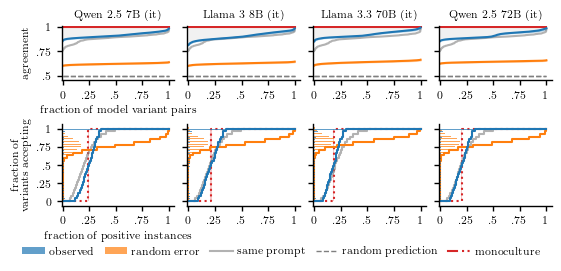

In [12]:
fig_width = plt.rcParams["figure.figsize"][0]  # 3*plt.rcParams["figure.figsize"][0]
fig_height = 0.8*plt.rcParams["figure.figsize"][1]

fig, axs = plt.subplots(
    2,
    len(MODELS),
    sharey="row",
    constrained_layout=True,
    figsize=(fig_width, fig_height),
    gridspec_kw={"height_ratios": [2,3]}
)

recourse_observed = {}
recourse_at_random = {}

for i, model in enumerate(models_to_plot):
    print(model)
    mask = df["model"] == model

    # get predictions of all variants
    predictions_model_variations = (
        df_with_predictions[mask].filter(like="score_").transpose()
    )
    # make index numeric again, change column name to model
    predictions_model_variations.index = predictions_model_variations.index.str.replace(
        "score_", "", regex=False
    ).astype(int)
    predictions_model_variations.columns = [model] * len(
        predictions_model_variations.columns
    )  # [f'{model}_' + str(col) for col in predictions_model_variations.columns]

    # # agreement
    plot_agreement_wrapper(
        ax=axs[0,i],
        predictions=predictions_same_prompt["ACSIncome"],
        df=df_same_prompt,
        xlabel="",
        ylabel="",
        plot_monoc = False,
        plot_baseline= False,
        fill_area_to_monoc=False,
        obs_color="C7",
        obs_alpha=0.6,
        obs_label="same prompt",
    )
    axs[0,i], agreement_data = plot_agreement_wrapper(
        ax=axs[0,i],
        predictions=predictions_model_variations,
        df=df[mask],
        xlabel="",
        ylabel="",
        bootstrap=True,
        num_samples=min(predictions_same_prompt[TASKS[0]].shape[1],predictions_model_variations.shape[1]),
        num_resamples=100,
        axis=1,
    )
    axs[0,i].set_title(f"{prettify_model_name(key_to_model(model))}")

    print(f"mean agreement: {agreement_data['observed'].agreement.mean():.4f}")
    print(
        f"mean agreement at random: {agreement_data['baseline'].agreement.mean():.4f}"
    )

    ## recourse
    plot_recourse_wrapper(
        ax=axs[1,i],
        predictions=predictions_same_prompt["ACSIncome"],
        df=df_same_prompt,
        xlabel="",
        ylabel="",
        plot_pdf = False,
        plot_monoc = False,
        plot_baseline= False,
        obs_color="C7",
        obs_alpha=0.6,
        obs_label="same prompt",
    )
    axs[1,i], observed, at_random = plot_recourse_wrapper(
        ax=axs[1,i],
        predictions=predictions_model_variations,
        df=df[mask],
        xlabel="",
        ylabel="",
        bootstrap=True,
        num_samples=predictions_same_prompt[TASKS[0]].shape[1],
        num_resamples=100,
        axis=1,
        plot_pdf = True
    )

    recourse_observed[model] = observed
    recourse_at_random[model] = at_random


axs[0, 0].set_ylabel("agreement")
axs[0, 0].set_xlabel("fraction of model variant pairs")

axs[1, 0].set_ylabel("fraction of\n variants accepting")
axs[1, 0].set_xlabel("fraction of positive instances")
configure_legend(fig, axs, offset=0.2, 
                 order = ["observed", "random error", "same prompt", "random prediction", "monoculture"], 
                 handletextpad=0.4, 
                 columnspacing=1)

file_name = build_filename(name="variations-agreement-recourse")
for ending in [".png", ".pdf"]:
    plt.savefig(FIGURES_PAPER_DIR / f"fig5_{file_name}{ending}")
print(file_name)

plt.show()

In [13]:
import numpy as np

output = f"{'model':20} &   M  & \tno recourse & substantial recourse & full recourse\\\\"

for model in recourse_observed.keys():

    mask = df["model"] == model

    M = predictions_same_prompt[TASKS[0]].shape[1]
    rec = recourse_observed[model]
    frac_models = rec[:, 1]
    frac_ind = rec[:, 0]
    max_frac_no_rec = (
        sum(frac_ind[frac_models == 0.0]) if sum(frac_models == 0.0) > 0 else 0.0
    )
    frac_limited_rec = (
        sum(frac_ind[frac_models <= 0.5]) if sum(frac_models <= 0.5) > 0 else 0.0
    )
    frac_substantial_rec = 1 - frac_limited_rec
    frac_full_rec = (
        sum(frac_ind[np.isclose(frac_models, 1.0)])
        if sum(np.isclose(frac_models, 1.0)) > 0
        else 0.0
    )
    output += (
        f"\n{prettify_model_name(key_to_model(model)):20} & {M:3}  &\t{max_frac_no_rec:.2f}"
        f"&\t{frac_substantial_rec:.2f}"
        f"&\t{frac_full_rec:.2f}\\\\"
    )

print(output)

# with open(FIGURES_PAPER_DIR / (build_filename("recourse_table_prompt_variations") + ".txt"), "w") as file:
#     file.write(output)

model                &   M  & 	no recourse & substantial recourse & full recourse\\
Qwen 2.5 7B (it)     &  27  &	0.11&	0.75&	0.63\\
Llama 3 8B (it)      &  27  &	0.09&	0.79&	0.64\\
Llama 3.3 70B (it)   &  27  &	0.08&	0.82&	0.70\\
Qwen 2.5 72B (it)    &  27  &	0.09&	0.80&	0.67\\
